# Sketch Classifier - Pictionary AI Trainer

This notebook trains a CNN model to recognize sketches in real-time, enabling competitive gameplay where the AI tries to guess what's being drawn.

## Project Plan:
1. **Load and explore the Quick, Draw! dataset**
2. **Generate partial drawings** (to simulate incomplete sketches)
3. **Build and train a CNN model**
4. **Evaluate performance**
5. **Save model for deployment**

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from PIL import Image, ImageDraw
import cv2

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.10.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def load_ndjson_dataset(filepath, max_samples=None):
    """
    Load Quick, Draw! dataset from NDJSON file.
    Returns list of drawing data dictionaries.
    """
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if max_samples and i >= max_samples:
                break
            try:
                data.append(json.loads(line.strip()))
            except json.JSONDecodeError:
                print(f"Warning: Skipped invalid JSON at line {i+1}")
                continue
    return data

def load_all_datasets(datasets_folder="datasetsReducidos", max_samples_per_class=None):
    """
    Load all NDJSON datasets from the datasetsReducidos folder.
    
    Args:
        datasets_folder: Path to folder containing reduced datasets
        max_samples_per_class: Maximum samples to load per class (None = all)
    
    Returns:
        List of all drawing dictionaries from all datasets
    """
    datasets_path = Path(datasets_folder)
    ndjson_files = sorted(datasets_path.glob("reduced_*.ndjson"))
    
    print(f"Found {len(ndjson_files)} dataset files")
    
    all_drawings = []
    
    for file_path in ndjson_files:
        # Extract class name from filename
        # "reduced_full_simplified_alarm clock.ndjson" -> "alarm clock"
        class_name = file_path.stem.replace("reduced_full_simplified_", "").replace("_", " ")
        
        drawings = load_ndjson_dataset(file_path, max_samples=max_samples_per_class)
        print(f"  Loaded {len(drawings):5d} drawings for '{class_name}'")
        
        all_drawings.extend(drawings)
    
    print(f"\nTotal drawings loaded: {len(all_drawings)}")
    
    # Get unique classes
    unique_classes = sorted(set(d['word'] for d in all_drawings))
    print(f"Total unique classes: {len(unique_classes)}")
    
    return all_drawings

# Load all datasets (ALL samples - memory efficient with generators!)
print("="*60)
print("LOADING ALL DATASETS FROM datasetsReducidos")
print("="*60)

drawings_data = load_all_datasets("datasetsReducidos")

# Display sample distribution
print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)

from collections import Counter
class_counts = Counter(d['word'] for d in drawings_data)
print(f"\nClasses and their counts:")
for word, count in sorted(class_counts.items())[:10]:  # Show first 10
    print(f"  {word:20s}: {count:5d} samples")
print(f"  ... ({len(class_counts) - 10} more classes)")

# Check a sample
if drawings_data:
    sample = drawings_data[0]
    print(f"\nSample structure:")
    print(f"  Keys: {list(sample.keys())}")
    print(f"  Word: {sample['word']}")
    print(f"  Country: {sample['countrycode']}")
    print(f"  Recognized: {sample['recognized']}")
    print(f"  Number of strokes: {len(sample['drawing'])}")

LOADING ALL DATASETS FROM datasetsReducidos
Found 230 dataset files
  Loaded  6072 drawings for 'aircraft carrier'
  Loaded  7912 drawings for 'airplane'
  Loaded  7912 drawings for 'airplane'
  Loaded  6459 drawings for 'alarm clock'
  Loaded  6459 drawings for 'alarm clock'
  Loaded  7757 drawings for 'ambulance'
  Loaded  7757 drawings for 'ambulance'
  Loaded  6283 drawings for 'arm'
  Loaded  8801 drawings for 'asparagus'
  Loaded  6283 drawings for 'arm'
  Loaded  8801 drawings for 'asparagus'
  Loaded  6477 drawings for 'axe'
  Loaded  6475 drawings for 'baseball bat'
  Loaded  6945 drawings for 'baseball'
  Loaded  6477 drawings for 'axe'
  Loaded  6475 drawings for 'baseball bat'
  Loaded  6945 drawings for 'baseball'
  Loaded  6142 drawings for 'basket'
  Loaded  6882 drawings for 'basketball'
  Loaded  6198 drawings for 'bat'
  Loaded  6142 drawings for 'basket'
  Loaded  6882 drawings for 'basketball'
  Loaded  6198 drawings for 'bat'
  Loaded  9110 drawings for 'bathtub'
 

In [3]:
def strokes_to_image(strokes, image_size=28, line_width=2):
    """
    Convert stroke data to a grayscale image.
    
    Args:
        strokes: List of strokes, where each stroke is [[x1,x2,...], [y1,y2,...]]
        image_size: Output image size (default 28x28)
        line_width: Width of the drawn lines
    
    Returns:
        numpy array of shape (image_size, image_size) with values 0-255
    """
    # Create a white image
    img = Image.new('L', (256, 256), color=255)
    draw = ImageDraw.Draw(img)
    
    # Draw each stroke
    for stroke in strokes:
        if len(stroke) < 2 or len(stroke[0]) < 2:
            continue
        
        x_coords = stroke[0]
        y_coords = stroke[1]
        
        # Draw lines between consecutive points
        for i in range(len(x_coords) - 1):
            draw.line(
                [(x_coords[i], y_coords[i]), (x_coords[i+1], y_coords[i+1])],
                fill=0,
                width=line_width
            )
    
    # Resize to target size
    img = img.resize((image_size, image_size), Image.Resampling.LANCZOS)
    
    # Convert to numpy array and normalize to [0, 1]
    img_array = np.array(img, dtype=np.float32) / 255.0
    
    # Invert so drawing is white on black background (better for CNNs)
    img_array = 1.0 - img_array
    
    return img_array

# # Test the conversion (only if drawing_info exists from Cell 5)
# try:
#     test_drawing = drawing_info[0]['strokes']
#     test_image = strokes_to_image(test_drawing)
    
#     print(f"Image shape: {test_image.shape}")
#     print(f"Image range: [{test_image.min():.2f}, {test_image.max():.2f}]")
    
#     # Visualize
#     plt.figure(figsize=(4, 4))
#     plt.imshow(test_image, cmap='gray')
#     plt.title(f"Sample: {drawing_info[0]['word']}")
#     plt.axis('off')
#     plt.show()
# except NameError:
#     print("⚠️ Run Cell 5 first to prepare the dataset, then come back to test the conversion.")

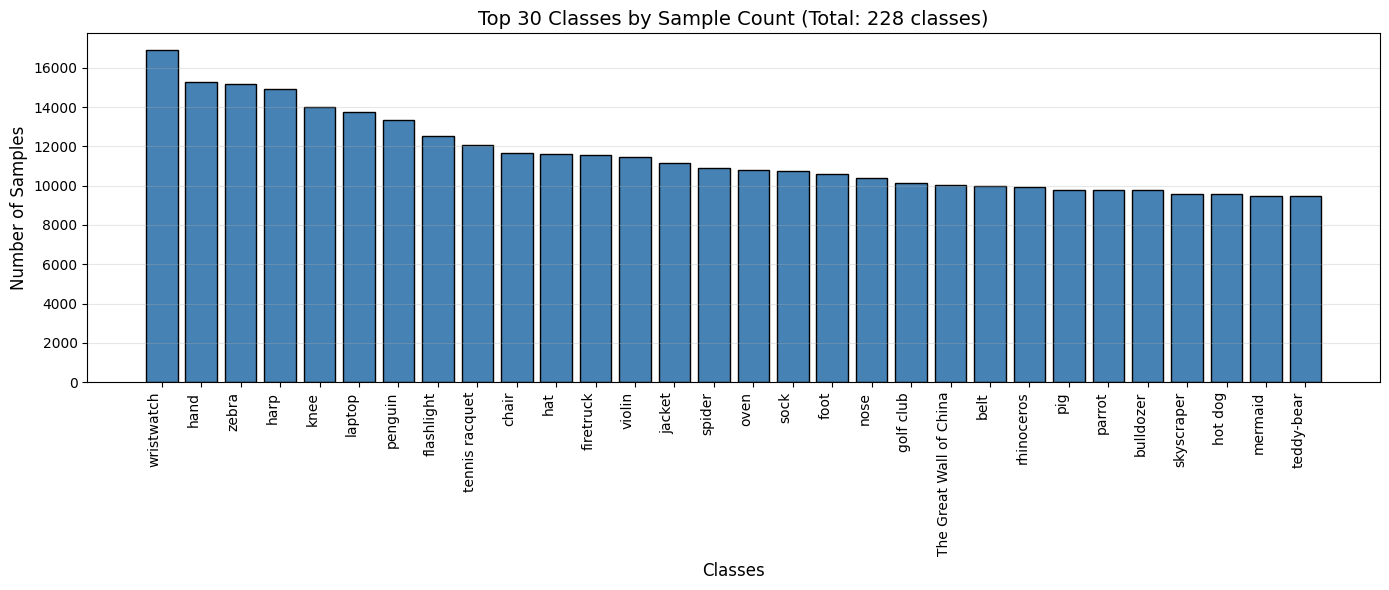


Dataset Balance:
  Total classes: 228
  Most common class: 'wristwatch' with 16912 samples
  Least common class: 'bed' with 5959 samples
  Average samples per class: 1519.1


In [4]:
from collections import Counter

# Count samples per class
class_counts = Counter(d['word'] for d in drawings_data)

# Sort by count
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Visualize top 30 classes
top_n = min(30, len(sorted_classes))
top_classes = sorted_classes[:top_n]
words, counts = zip(*top_classes)

plt.figure(figsize=(14, 6))
plt.bar(range(len(words)), counts, color='steelblue', edgecolor='black')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title(f'Top {top_n} Classes by Sample Count (Total: {len(class_counts)} classes)', fontsize=14)
plt.xticks(range(len(words)), words, rotation=90, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nDataset Balance:")
print(f"  Total classes: {len(class_counts)}")
print(f"  Most common class: '{sorted_classes[0][0]}' with {sorted_classes[0][1]} samples")
print(f"  Least common class: '{sorted_classes[-1][0]}' with {sorted_classes[-1][1]} samples")
print(f"  Average samples per class: {sum(counts) / len(sorted_classes):.1f}")

## 2.5 Visualize Dataset Distribution

In [5]:
# def generate_partial_strokes(strokes, completion_ratio):
#     """
#     Generate a partial version of strokes based on completion ratio.
    
#     Args:
#         strokes: Full stroke data
#         completion_ratio: Float between 0 and 1 (e.g., 0.3 = 30% complete)
    
#     Returns:
#         Partial strokes
#     """
#     if completion_ratio >= 1.0:
#         return strokes
    
#     total_strokes = len(strokes)
#     num_strokes = max(1, int(total_strokes * completion_ratio))
    
#     return strokes[:num_strokes]

# # Test with different completion levels
# completion_levels = [0.1, 0.3, 0.5, 0.7, 1.0]

# fig, axes = plt.subplots(1, len(completion_levels), figsize=(15, 3))
# fig.suptitle(f"Progressive Drawing: {drawings_data[0]['word']}", fontsize=14)

# for idx, completion in enumerate(completion_levels):
#     partial_strokes = generate_partial_strokes(test_drawing, completion)
#     partial_image = strokes_to_image(partial_strokes)
    
#     axes[idx].imshow(partial_image, cmap='gray')
#     axes[idx].set_title(f"{int(completion*100)}% complete")
#     axes[idx].axis('off')

# plt.tight_layout()
# plt.show()

In [6]:
import gc

# Create label mappings first
words = sorted(set(d['word'] for d in drawings_data))
label_to_idx = {word: idx for idx, word in enumerate(words)}
idx_to_label = {v: k for k, v in label_to_idx.items()}

print(f"Found {len(words)} unique classes")
print(f"Total drawings: {len(drawings_data)}")

# Save drawing data with labels for generator
drawing_info = []
for d in drawings_data:
    drawing_info.append({
        'strokes': d['drawing'],
        'label': label_to_idx[d['word']],
        'word': d['word']
    })

print(f"Prepared {len(drawing_info)} drawing references")

# Shuffle the data
random.shuffle(drawing_info)

# Split indices for train/val/test
total = len(drawing_info)
train_size = int(0.70 * total)
val_size = int(0.15 * total)

train_data = drawing_info[:train_size]
val_data = drawing_info[train_size:train_size + val_size]
test_data = drawing_info[train_size + val_size:]

print(f"\nDataset split:")
print(f"  Train: {len(train_data)} samples (70%)")
print(f"  Validation: {len(val_data)} samples (15%)")
print(f"  Test: {len(test_data)} samples (15%)")

# Clear original data to free memory
del drawings_data
gc.collect()
print("\n✓ Original data cleared from memory")

Found 228 unique classes
Total drawings: 1723505
Prepared 1723505 drawing references
Prepared 1723505 drawing references

Dataset split:
  Train: 1206453 samples (70%)
  Validation: 258525 samples (15%)
  Test: 258527 samples (15%)

✓ Original data cleared from memory

Dataset split:
  Train: 1206453 samples (70%)
  Validation: 258525 samples (15%)
  Test: 258527 samples (15%)

✓ Original data cleared from memory


In [7]:
class SketchDataGenerator(keras.utils.Sequence):
    """
    Memory-efficient data generator that loads and processes images on-the-fly.
    """
    def __init__(self, data, batch_size=128, image_size=28, shuffle=True):
        self.data = data
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()
    
    def __len__(self):
        """Number of batches per epoch"""
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, index):
        """Generate one batch of data"""
        # Get batch indices
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.data))
        batch_indices = self.indices[start_idx:end_idx]
        
        # Generate batch
        X_batch = []
        y_batch = []
        
        for i in batch_indices:
            item = self.data[i]
            img = strokes_to_image(item['strokes'], self.image_size)
            X_batch.append(img)
            y_batch.append(item['label'])
        
        X_batch = np.array(X_batch, dtype=np.float32).reshape(-1, self.image_size, self.image_size, 1)
        y_batch = np.array(y_batch, dtype=np.int32)
        
        return X_batch, y_batch
    
    def on_epoch_end(self):
        """Shuffle data after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create generators
print("="*60)
print("CREATING DATA GENERATORS")
print("="*60)

batch_size = 128

train_generator = SketchDataGenerator(train_data, batch_size=batch_size, shuffle=True)
val_generator = SketchDataGenerator(val_data, batch_size=batch_size, shuffle=False)
test_generator = SketchDataGenerator(test_data, batch_size=batch_size, shuffle=False)

print(f"✓ Train generator: {len(train_generator)} batches")
print(f"✓ Validation generator: {len(val_generator)} batches")
print(f"✓ Test generator: {len(test_generator)} batches")
print(f"\nMemory usage: Minimal (loads batches on-the-fly)")

# Test generator
print("\nTesting generator...")
X_test_batch, y_test_batch = train_generator[0]
print(f"  Batch shape: {X_test_batch.shape}")
print(f"  Labels shape: {y_test_batch.shape}")
print(f"  Batch memory: ~{X_test_batch.nbytes / (1024**2):.2f} MB")

num_classes = len(label_to_idx)

CREATING DATA GENERATORS
✓ Train generator: 9426 batches
✓ Validation generator: 2020 batches
✓ Test generator: 2020 batches

Memory usage: Minimal (loads batches on-the-fly)

Testing generator...
  Batch shape: (128, 28, 28, 1)
  Labels shape: (128,)
  Batch memory: ~0.38 MB


## 5.5 Create Data Generators (Memory Efficient)

Using generators to load and process images on-the-fly instead of loading all into RAM.

In [8]:
def build_sketch_cnn(input_shape=(28, 28, 1), num_classes=1):
    """
    Build an IMPROVED CNN for sketch classification.
    
    Enhanced architecture with:
    - Deeper network (4 conv blocks instead of 3)
    - More filters to capture complex patterns
    - Residual-like connections via concatenation
    - Larger dense layers for better classification
    - Optimized for 108 classes
    """
    model = keras.Sequential([
        # First block - Basic edge detection
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second block - More complex features
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third block - High-level patterns
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth block - Very high-level features
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        
        # Global pooling - reduces parameters while keeping spatial info
        layers.GlobalAveragePooling2D(),
        
        # Larger classifier for 108 classes
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
    ])
    
    return model

# Build the model
num_classes = len(label_to_idx)
model = build_sketch_cnn(input_shape=(28, 28, 1), num_classes=num_classes)

# Compile with IMPROVED settings for deeper network
if num_classes > 1:
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=0.001,  # Slightly lower LR for more stable training with deeper network
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
    )
else:
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

# Display model architecture
print("="*60)
print("MODEL ARCHITECTURE")
print("="*60)
model.summary()
print("\nTotal parameters: {:,}".format(model.count_params()))
print("="*60)

MODEL ARCHITECTURE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1

In [9]:
# Define callbacks with IMPROVED settings for deeper network
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=7,  # More patience for deeper network (needs more time to converge)
        restore_best_weights=True,
        verbose=1,
        mode='max',
        min_delta=0.001  # 0.1% improvement threshold
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,  # Reduce LR by half
        patience=3,  # Reduce LR if no improvement after 3 epochs
        min_lr=1e-6,
        verbose=1,
        mode='max',
        min_delta=0.001
    ),
    keras.callbacks.ModelCheckpoint(
        'best_sketch_model.keras',  # Use native Keras format
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    # Cosine decay with warmup
    keras.callbacks.LearningRateScheduler(
        lambda epoch: 0.001 * (0.92 ** epoch),  # Gentler decay for deeper network
        verbose=0
    )
]

# Train the model with generators (IMPROVED ARCHITECTURE)
print("="*60)
print("STARTING TRAINING (IMPROVED DEEPER CNN)")
print("="*60)
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Classes: {num_classes}")
print(f"Batch size: {batch_size}")
print(f"Model parameters: {model.count_params():,}")
print("="*60)
print("\n⚡ Optimizations applied:")
print("\n⚡ Key improvements:")
print("  - DEEPER architecture (4 conv blocks, 64→128→256→512 filters)")
print("  - 2 conv layers per block for better feature learning")
print("  - Larger dense layers (512→256 neurons)")
print("  - Lower initial LR (0.001) for stable training")
print("  - More patience (7 epochs) for deeper convergence")
print("  - Gentler LR decay (0.92)")
print("="*60 + "\n")

import time
start_time = time.time()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # More epochs for deeper network to converge
    callbacks=callbacks,
    verbose=1,
)

training_time = time.time() - start_time

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"Total epochs trained: {len(history.history['loss'])}")
print(f"Training time: {training_time/60:.1f} minutes ({training_time/3600:.2f} hours)")
print(f"Average time per epoch: {training_time/len(history.history['loss']):.1f} seconds")
print(f"\nBest validation accuracy: {max(history.history['val_accuracy']):.4f}")
if 'val_top_5_accuracy' in history.history:
    print(f"Best validation top-5 accuracy: {max(history.history['val_top_5_accuracy']):.4f}")
print(f"Final learning rate: {model.optimizer.learning_rate.numpy():.6f}")
print("="*60)

STARTING TRAINING (IMPROVED DEEPER CNN)
Training samples: 1206453
Validation samples: 258525
Classes: 228
Batch size: 128
Model parameters: 2,783,908

⚡ Optimizations applied:

⚡ Key improvements:
  - DEEPER architecture (4 conv blocks, 64→128→256→512 filters)
  - 2 conv layers per block for better feature learning
  - Larger dense layers (512→256 neurons)
  - Lower initial LR (0.001) for stable training
  - More patience (7 epochs) for deeper convergence
  - Gentler LR decay (0.92)

Epoch 1/20
Epoch 1/20
9425/9426 [============================>.] - ETA: 0s - loss: 1.9932 - accuracy: 0.5287 - top_5_accuracy: 0.7788
Epoch 1: val_accuracy improved from -inf to 0.70591, saving model to best_sketch_model.keras

Epoch 1: val_accuracy improved from -inf to 0.70591, saving model to best_sketch_model.keras
9426/9426 [==============================] - 357s 38ms/step - loss: 1.9931 - accuracy: 0.5287 - top_5_accuracy: 0.7788 - val_loss: 1.1789 - val_accuracy: 0.7059 - val_top_5_accuracy: 0.8993 

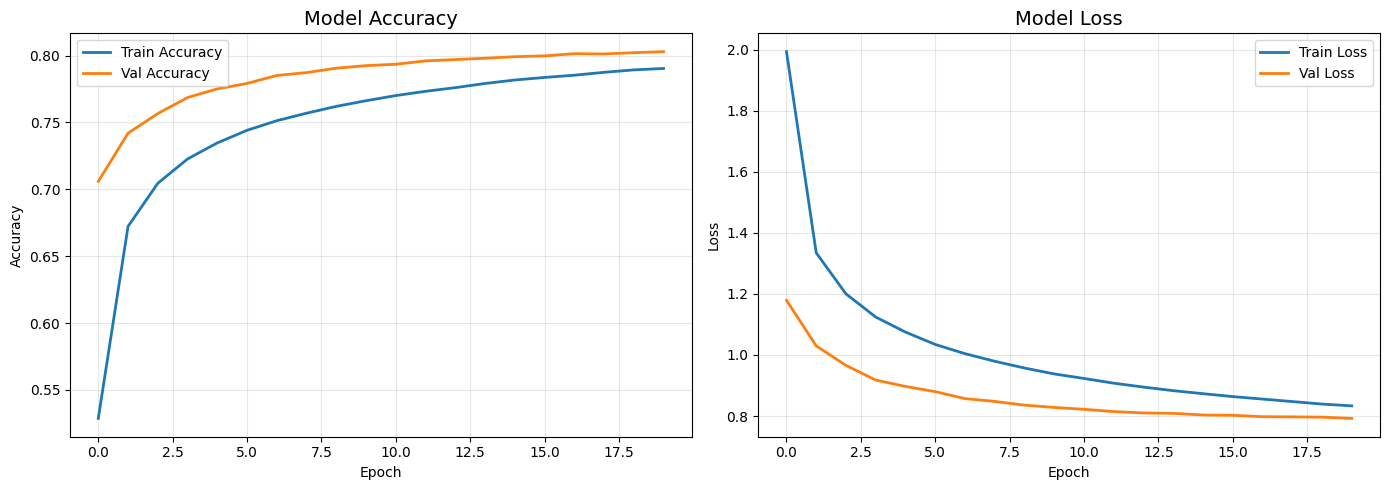


Final Training Metrics:
  Train Accuracy: 0.7903
  Val Accuracy: 0.8029
  Train Loss: 0.8332
  Val Loss: 0.7922


In [10]:


# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Training Metrics:")
print(f"  Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Val Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Train Loss: {history.history['loss'][-1]:.4f}")
print(f"  Val Loss: {history.history['val_loss'][-1]:.4f}")

2020/2020 [==============================] - 63s 31ms/step - loss: 0.7954 - accuracy: 0.8026 - top_5_accuracy: 0.9384

TEST SET PERFORMANCE
  Test Accuracy: 0.8026 (80.26%)
  Test Top-5 Accuracy: 0.9384 (93.84%)
  Test Loss: 0.7954

Generating sample predictions...

TEST SET PERFORMANCE
  Test Accuracy: 0.8026 (80.26%)
  Test Top-5 Accuracy: 0.9384 (93.84%)
  Test Loss: 0.7954

Generating sample predictions...


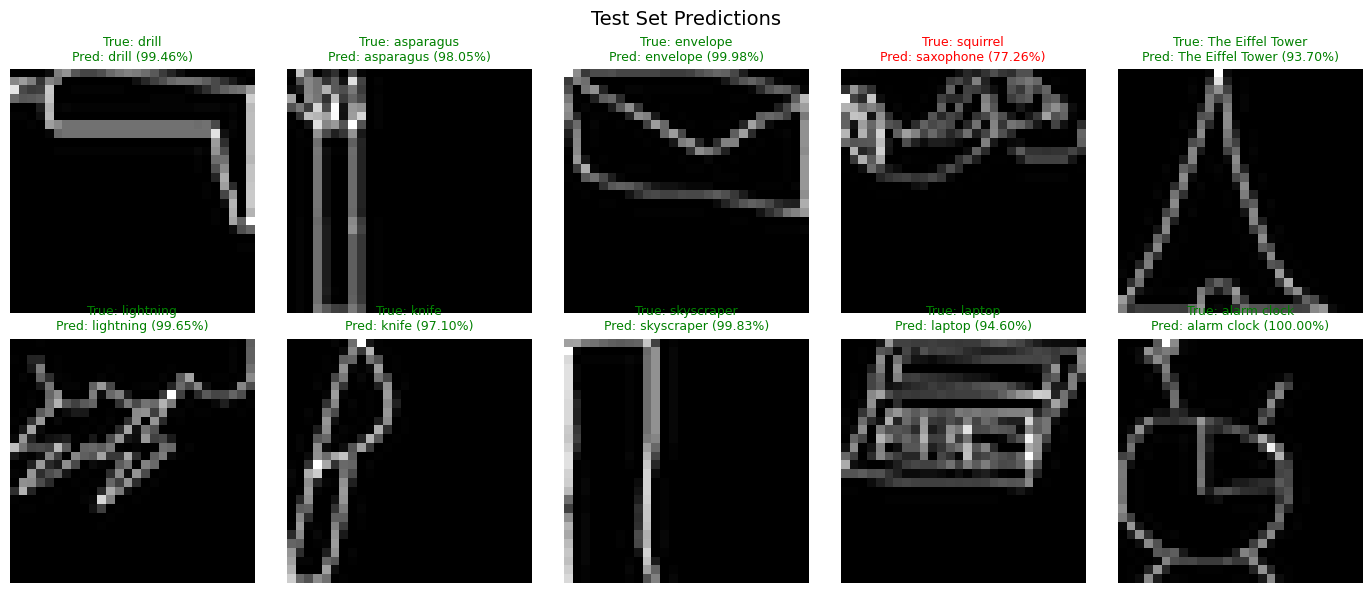

In [11]:
# Evaluate on test set using generator
test_results = model.evaluate(test_generator, verbose=1)
test_loss = test_results[0]
test_accuracy = test_results[1]
if len(test_results) > 2:
    test_top5_accuracy = test_results[2]

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
if len(test_results) > 2:
    print(f"  Test Top-5 Accuracy: {test_top5_accuracy:.4f} ({test_top5_accuracy*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")
print("="*60)

# Make predictions on a sample of test data
print("\nGenerating sample predictions...")
sample_size = 10
sample_indices = random.sample(range(len(test_data)), sample_size)

fig, axes = plt.subplots(2, 5, figsize=(14, 6))
fig.suptitle("Test Set Predictions", fontsize=14)

for i, ax in enumerate(axes.flat):
    item = test_data[sample_indices[i]]
    img = strokes_to_image(item['strokes'], 28)
    img_input = img.reshape(1, 28, 28, 1)
    
    prediction = model.predict(img_input, verbose=0)
    pred_idx = np.argmax(prediction[0])
    confidence = prediction[0][pred_idx]
    
    true_label = item['word']
    pred_label = idx_to_label[pred_idx]
    
    ax.imshow(img, cmap='gray')
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2%})", 
                 color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

PROGRESSIVE PREDICTION ANALYSIS (100 Random Test Samples)

Results from 100 samples:
  Successfully guessed: 92/100 (92.0%)
  Never guessed correctly: 8/100 (8.0%)

Average completion needed: 47.6%
Median completion needed: 50.0%
Min completion needed: 10.0%
Max completion needed: 100.0%

SHOWING 10 RANDOM EXAMPLES WITH PROGRESSIVE STEPS

Results from 100 samples:
  Successfully guessed: 92/100 (92.0%)
  Never guessed correctly: 8/100 (8.0%)

Average completion needed: 47.6%
Median completion needed: 50.0%
Min completion needed: 10.0%
Max completion needed: 100.0%

SHOWING 10 RANDOM EXAMPLES WITH PROGRESSIVE STEPS

Sample 1: 'remote control' (Correctly guessed at 20%)
   20%: remote control       (89.1%) ✓ CORRECT!
   40%: remote control       (98.6%) ✓ CORRECT!
   60%: remote control       (99.6%) ✓ CORRECT!
   80%: remote control       (99.3%) ✓ CORRECT!
  100%: remote control       (99.2%) ✓ CORRECT!

Sample 2: 'sword' (Correctly guessed at 10%)

Sample 1: 'remote control' (Correctl

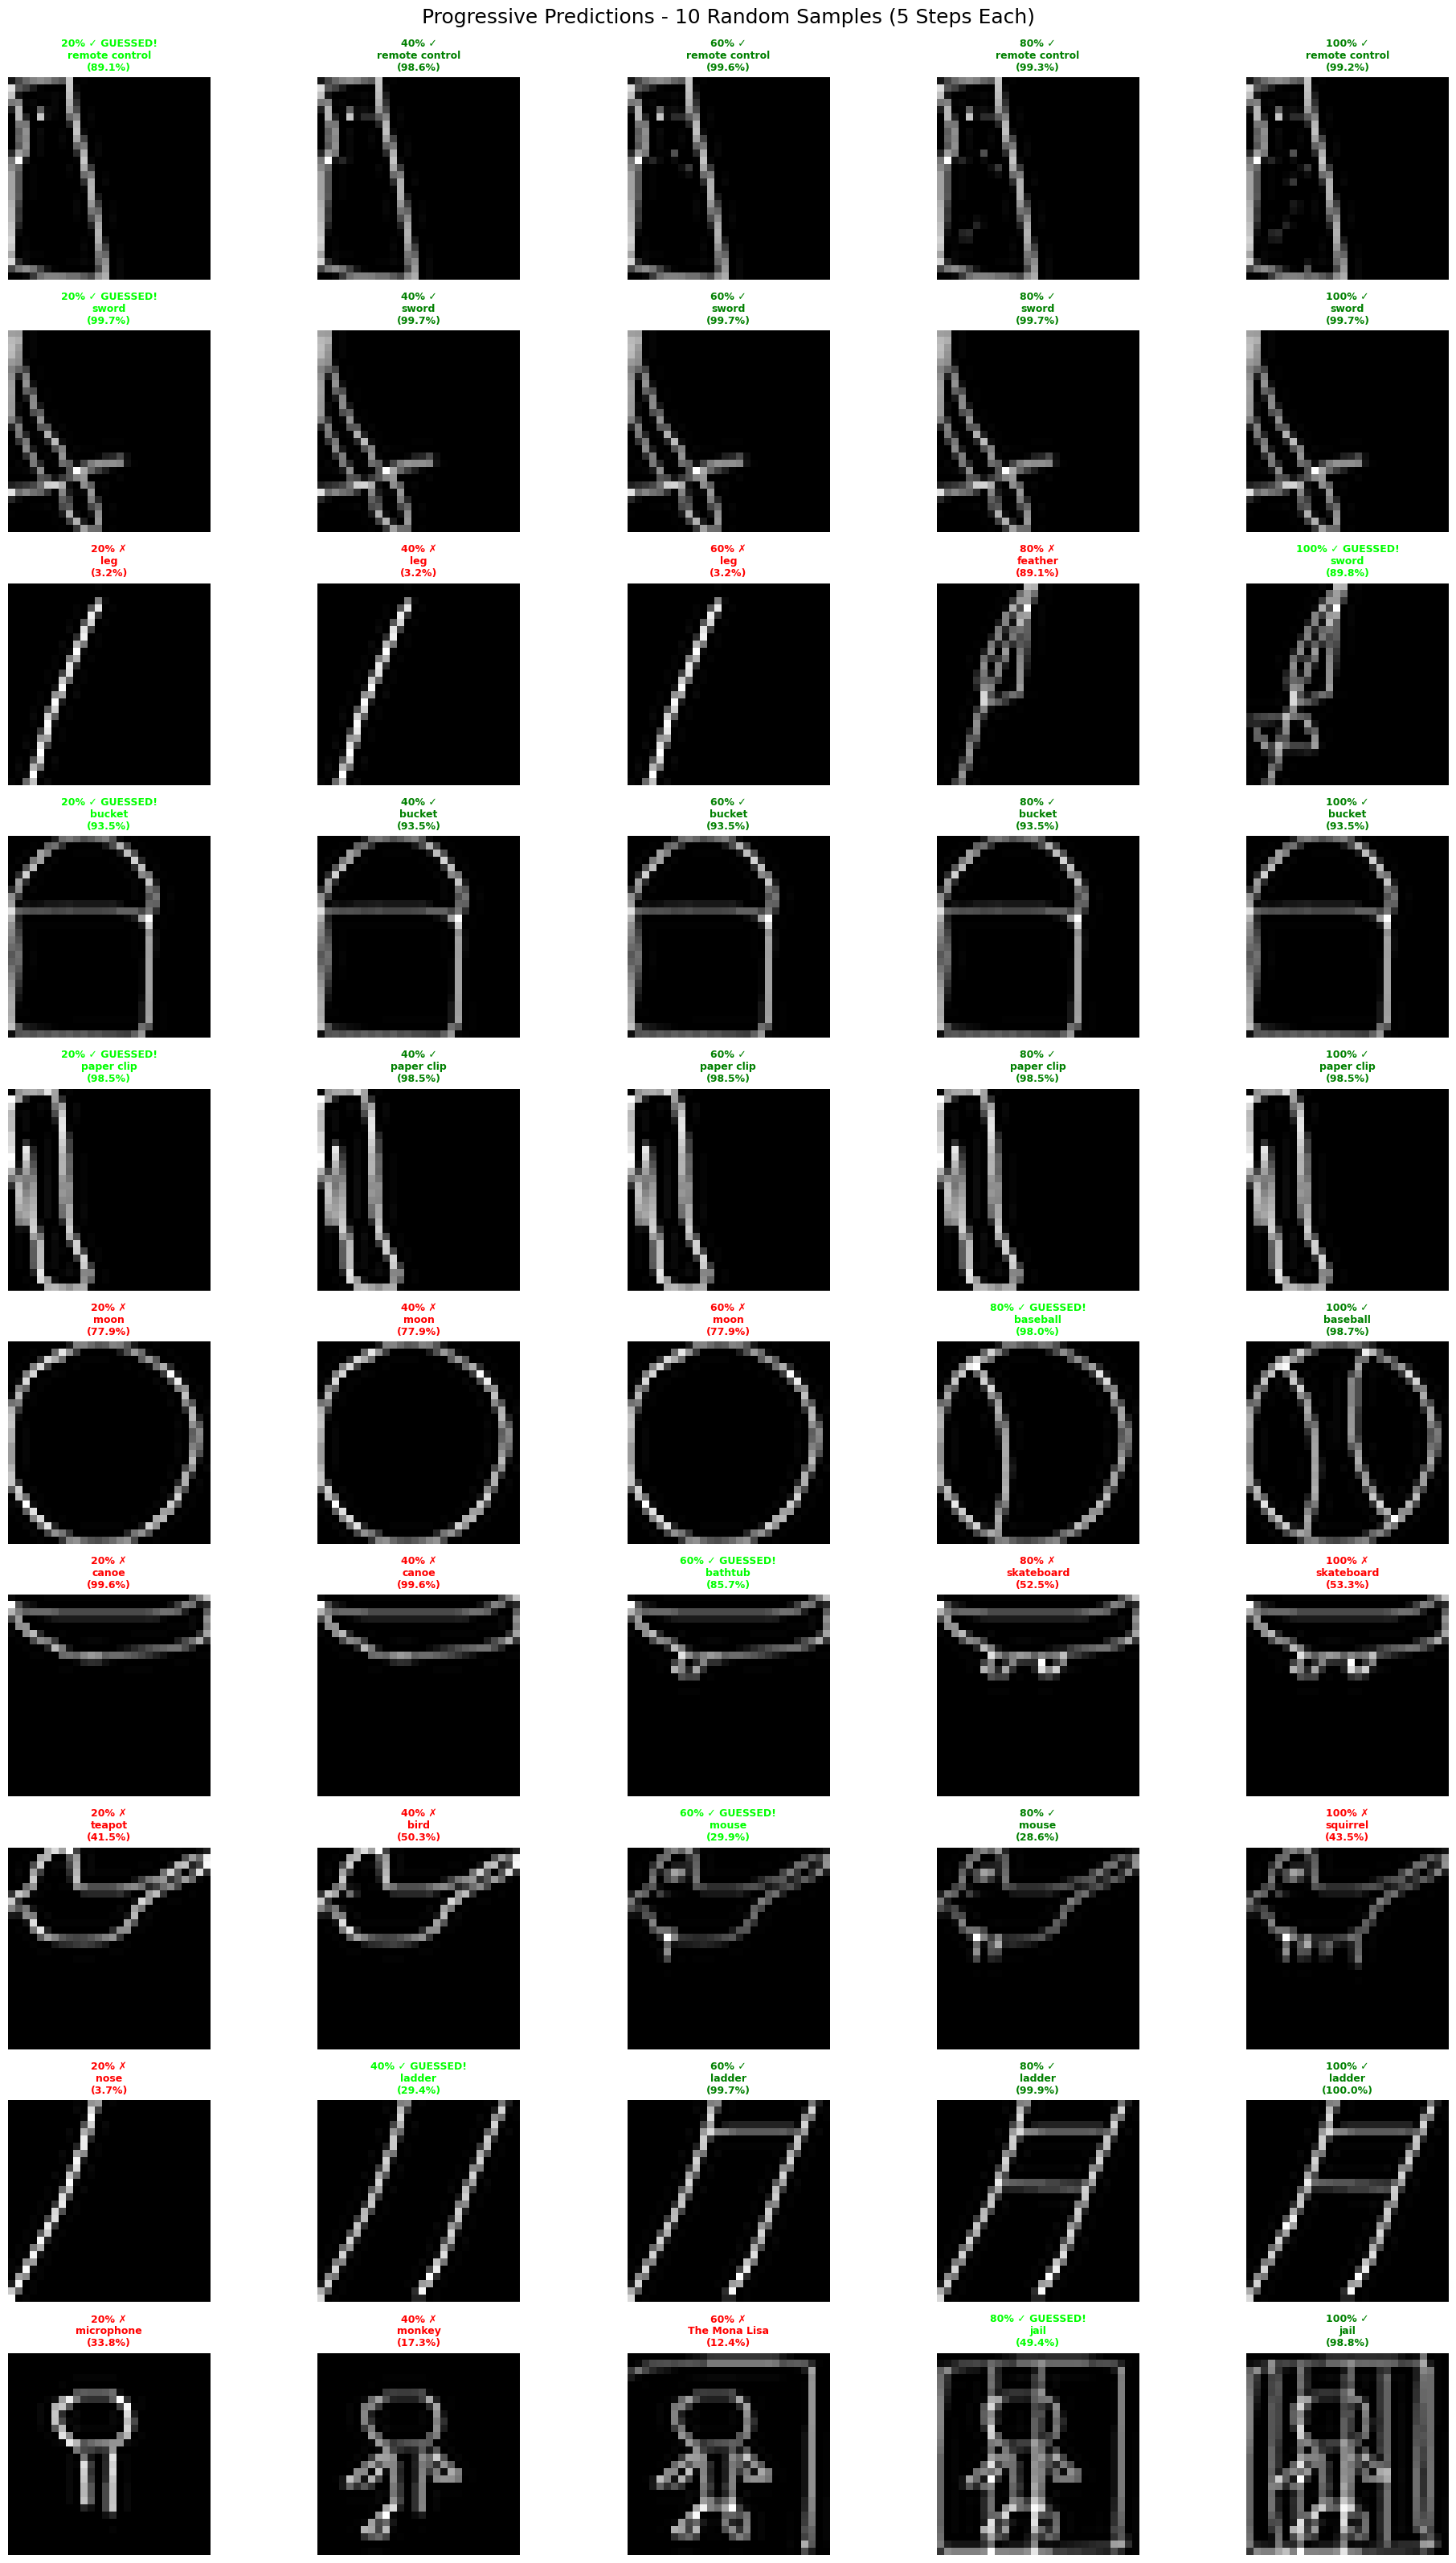


✓ Analysis complete!


In [17]:
# Test 100 random samples to find average completion needed for correct prediction
def generate_partial_strokes(strokes, completion_ratio):
    """Generate a partial version of strokes based on completion ratio."""
    if completion_ratio >= 1.0:
        return strokes
    total_strokes = len(strokes)
    num_strokes = max(1, int(total_strokes * completion_ratio))
    return strokes[:num_strokes]

print("="*60)
print("PROGRESSIVE PREDICTION ANALYSIS (100 Random Test Samples)")
print("="*60)

# Select 100 random test samples
num_samples = 100
sample_indices = random.sample(range(len(test_data)), num_samples)
completion_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Store results
results = []

for sample_idx in sample_indices:
    test_sample = test_data[sample_idx]
    true_label = test_sample['word']
    
    # Find the minimum completion percentage where prediction is correct
    min_correct_completion = None
    
    for completion in completion_levels:
        partial_strokes = generate_partial_strokes(test_sample['strokes'], completion)
        partial_image = strokes_to_image(partial_strokes)
        img_input = partial_image.reshape(1, 28, 28, 1)
        
        prediction = model.predict(img_input, verbose=0)
        pred_idx = np.argmax(prediction[0])
        pred_label = idx_to_label[pred_idx]
        confidence = prediction[0][pred_idx]
        
        if pred_label == true_label:
            min_correct_completion = completion
            break
    
    # If never correct, set to 1.1 (never guessed correctly)
    if min_correct_completion is None:
        min_correct_completion = 1.1
    
    results.append({
        'sample': test_sample,
        'min_completion': min_correct_completion,
        'true_label': true_label
    })

# Calculate statistics
correct_guesses = [r['min_completion'] for r in results if r['min_completion'] <= 1.0]
never_correct = len([r for r in results if r['min_completion'] > 1.0])

print(f"\nResults from {num_samples} samples:")
print(f"  Successfully guessed: {len(correct_guesses)}/{num_samples} ({len(correct_guesses)/num_samples*100:.1f}%)")
print(f"  Never guessed correctly: {never_correct}/{num_samples} ({never_correct/num_samples*100:.1f}%)")

if correct_guesses:
    avg_completion = np.mean(correct_guesses) * 100
    median_completion = np.median(correct_guesses) * 100
    print(f"\nAverage completion needed: {avg_completion:.1f}%")
    print(f"Median completion needed: {median_completion:.1f}%")
    print(f"Min completion needed: {min(correct_guesses)*100:.1f}%")
    print(f"Max completion needed: {max(correct_guesses)*100:.1f}%")

# Display 10 random examples with 5 progressive steps each
print("\n" + "="*60)
print("SHOWING 10 RANDOM EXAMPLES WITH PROGRESSIVE STEPS")
print("="*60)

# Select 10 random samples to display
display_samples = random.sample(results, min(10, len(results)))

# Use 5 completion steps to show progression
display_steps = [0.2, 0.4, 0.6, 0.8, 1.0]

fig, axes = plt.subplots(10, 5, figsize=(20, 32))
fig.suptitle(f"Progressive Predictions - 10 Random Samples (5 Steps Each)", fontsize=18, y=0.995)

for sample_idx, result in enumerate(display_samples):
    test_sample = result['sample']
    true_label = result['true_label']
    min_correct = result['min_completion']
    
    print(f"\nSample {sample_idx + 1}: '{true_label}' (Correctly guessed at {int(min_correct*100) if min_correct <= 1.0 else 'Never'}%)")
    
    # Track predictions across steps
    for step_idx, completion in enumerate(display_steps):
        ax = axes[sample_idx, step_idx]
        
        # Generate partial drawing
        partial_strokes = generate_partial_strokes(test_sample['strokes'], completion)
        partial_image = strokes_to_image(partial_strokes)
        
        # Get prediction
        img_input = partial_image.reshape(1, 28, 28, 1)
        prediction = model.predict(img_input, verbose=0)
        pred_idx = np.argmax(prediction[0])
        pred_label = idx_to_label[pred_idx]
        confidence = prediction[0][pred_idx]
        
        # Display image
        ax.imshow(partial_image, cmap='gray')
        
        # Determine title color and text
        is_correct = (pred_label == true_label)
        just_guessed = (min_correct <= completion and min_correct > (display_steps[step_idx-1] if step_idx > 0 else 0))
        
        if is_correct and just_guessed:
            color = 'lime'  # Bright green when it just got it right
            marker = "✓ GUESSED!"
        elif is_correct:
            color = 'green'  # Normal green if already correct
            marker = "✓"
        else:
            color = 'red'  # Red if wrong
            marker = "✗"
        
        title = f"{int(completion*100)}% {marker}\n{pred_label}\n({confidence:.1%})"
        ax.set_title(title, color=color, fontsize=9, fontweight='bold')
        ax.axis('off')
        
        # Print to console
        status = "✓ CORRECT!" if is_correct else "✗ Wrong"
        print(f"  {int(completion*100):3d}%: {pred_label:20s} ({confidence:.1%}) {status}")

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✓ Analysis complete!")
print("="*60)

In [13]:
import pickle

# Save the model
model.save('sketch_classifier_model.h5')
print("✓ Model saved as 'sketch_classifier_model.h5'")

# Save the model
model.save('sketch_classifier_model.keras')
print("✓ Model saved as 'sketch_classifier_model.keras'")

# Save label mappings
with open('label_mappings.pkl', 'wb') as f:
    pickle.dump({
        'label_to_idx': label_to_idx,
        'idx_to_label': idx_to_label
    }, f)
print("✓ Label mappings saved as 'label_mappings.pkl'")

# Save model info
model_info = {
    'input_shape': (28, 28, 1),
    'num_classes': num_classes,
    'classes': list(label_to_idx.keys()),
    'test_accuracy': float(test_accuracy),
    'total_params': model.count_params(),
    'image_size': 28
}

with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print("✓ Model info saved as 'model_info.json'")

print("\n" + "="*60)
print("MODEL TRAINING COMPLETE!")
print("="*60)
print(f"Classes: {list(label_to_idx.keys())}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Total Parameters: {model.count_params():,}")
print("\nFiles saved:")
print("  - sketch_classifier_model.h5")
print("  - label_mappings.pkl")
print("  - model_info.json")
print("  - best_sketch_model.h5 (checkpoint)")
print("="*60)

✓ Model saved as 'sketch_classifier_model.h5'
✓ Model saved as 'sketch_classifier_model.keras'
✓ Label mappings saved as 'label_mappings.pkl'
✓ Model info saved as 'model_info.json'

MODEL TRAINING COMPLETE!
Classes: ['The Eiffel Tower', 'The Great Wall of China', 'The Mona Lisa', 'aircraft carrier', 'airplane', 'alarm clock', 'ambulance', 'arm', 'asparagus', 'axe', 'baseball', 'baseball bat', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'book', 'boomerang', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'camel', 'camera', 'cannon', 'canoe', 'carrot', 'cat', 'ceiling fan', 'cell phone', 'chair', 'chandelier', 'church', 'computer', 'cookie', 'couch', 'crab', 'crown', 'dolphin', 'donut', 'drill', 'drums', 'duck', 'dumbbell', 'ear', 'elephant', 'envelope', 'eraser', 'fan', 'feather', 'fence', 'finger', '